### STK 4021 2021 Oblig

#### Problem 4 - Rats

#### Import

In [34]:
import autograd.numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
from autograd import grad, hessian
from scipy.optimize import minimize
import arviz as az
from scipy.stats import gaussian_kde as kde
import math

#### Data

In [35]:
m = 6
x = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
y = np.array([2, 1, 2, 2, 3, 4, 1, 2, 5, 3])

#### Functions

In [36]:
def H(arg):
    return np.exp(arg) / (1 + np.exp(arg))


def p(x, a, b):
    arg = a + b * x
    return H(arg)


def ell(a, b, x, y):
    # omitting the binomial coefficient term
    p_vec = p(x, a, b)
    return np.sum(y * np.log(p_vec) + (m - y) * np.log(1 - p_vec))
    

#### (a)

In [37]:
res = minimize(lambda params: -ell(params[0], params[1], x, y), x0=np.zeros(2))
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 39.46178286453997
        x: [-1.173e+00  7.471e-01]
      nit: 6
      jac: [ 0.000e+00  4.768e-07]
 hess_inv: [[ 3.636e-01 -2.554e-01]
            [-2.554e-01  2.226e-01]]
     nfev: 24
     njev: 8

In [38]:
mle = res.x
print(f'Maximum likelihood estimate of a: {np.round(mle[0], 4)}')
print(f'Maximum likelihood estimate of b: {np.round(mle[1], 4)}')

Maximum likelihood estimate of a: -1.1735
Maximum likelihood estimate of b: 0.7471


#### Plot

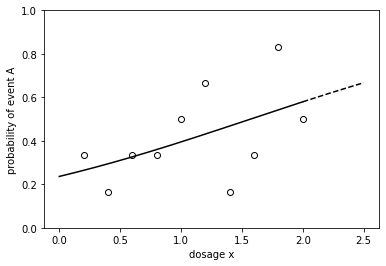

In [39]:
mplot = 200
space1 = np.linspace(0, 2.0, mplot)
space2 = np.linspace(2.0, 2.5, mplot)

plt.plot(space1, H(mle[0] + space1 * mle[1]), color='black')
plt.plot(space2, H(mle[0] + space2 * mle[1]), color='black', linestyle='dashed')
plt.scatter(x, y / m, facecolor='white', edgecolor='black')
plt.ylim(0, 1)
plt.xlabel('dosage x')
plt.ylabel('probability of event A')
plt.show()

#### (b)

In [40]:
sim = 10_000
sample = np.zeros((sim, 2))

for s in range(sim):
    if s == 0:
        sample[s] = 16 * np.random.random(2) - 8
    else:
        current = sample[s - 1]
        proposal = current + (2 * np.random.random(2) - 1)
        if np.max(proposal) > 8 or np.min(proposal < -8):
            sample[s] = current
        else:
            log_acceptance_prob = ell(proposal[0], proposal[1], x, y) - ell(current[0], current[1], x, y)
            U = np.random.random()
            if np.log(U) < log_acceptance_prob:
                sample[s] = proposal
            else:
                sample[s] = current
                
### burn-in
sample = sample[int(.05 * sim):]

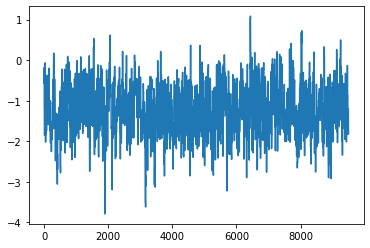

In [41]:
plt.plot(np.arange(len(sample[:, 0])), sample[:, 0])
plt.show()

#### Convergence diagnostics

In [42]:
ess1 = az.ess(sample[:, 0])
ess2 = az.ess(sample[:, 1])

print(f'ESS for a: {np.round(ess1, 2)}')
print(f'ESS for b: {np.round(ess2, 2)}')

ESS for a: 376.35
ESS for b: 403.93


#### Posterior means and standard deviations

In [43]:
post_mean_a = np.mean(sample[:, 0])
post_mean_b = np.mean(sample[:, 1])

post_sd_a = np.std(sample[:, 0])
post_sd_b = np.std(sample[:, 1])

print(f'Posterior mean of a: {np.round(post_mean_a, 4)}')
print(f'Posterior mean of b: {np.round(post_mean_b, 4)}')
print('')
print(f'Posterior standard deviation of a: {np.round(post_sd_a, 4)}')
print(f'Posterior standard deviation of b: {np.round(post_sd_b, 4)}')

Posterior mean of a: -1.2233
Posterior mean of b: 0.7768

Posterior standard deviation of a: 0.6286
Posterior standard deviation of b: 0.4921


#### Lazy Bayes

In [44]:
hess = hessian(lambda params: ell(params[0], params[1], x, y))(mle)
A = -inv(hess)

print(f'Posterior lazy Bayes standard deviation of a: {np.round(np.sqrt(A[0][0]), 4)}')
print(f'Posterior lazy Bayes standard deviation of b: {np.round(np.sqrt(A[1][1]), 4)}')

Posterior lazy Bayes standard deviation of a: 0.6038
Posterior lazy Bayes standard deviation of b: 0.4746


We see that lazy Bayes does very well.

#### (c)

In [45]:
space = np.linspace(0, 2.5, mplot).reshape((mplot, 1))
a_plus_bx_sample = (sample[:, 0] + space * sample[:, 1]).T
lower90 = np.quantile(a_plus_bx_sample, .05, axis=0)
upper90 = np.quantile(a_plus_bx_sample, .95, axis=0)

#### Plot

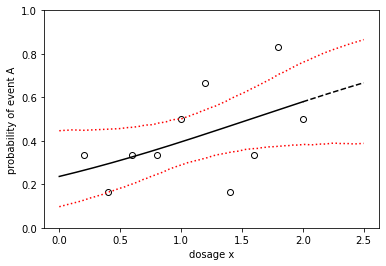

In [46]:
space = np.linspace(0, 2.5, mplot)

plt.plot(space1, H(mle[0] + space1 * mle[1]), color='black')
plt.plot(space2, H(mle[0] + space2 * mle[1]), color='black', linestyle='dashed')
plt.plot(space, H(lower90), color='red', linestyle='dotted')
plt.plot(space, H(upper90), color='red', linestyle='dotted')
plt.scatter(x, y / m, facecolor='white', edgecolor='black')
plt.ylim(0, 1)
plt.xlabel('dosage x')
plt.ylabel('probability of event A')
plt.show()

#### (d)

In [47]:
xnew = 2.5
pxnew_sample = H(sample[:, 0] + sample[:, 1] * xnew)
density = kde(pxnew_sample)

#### Plot

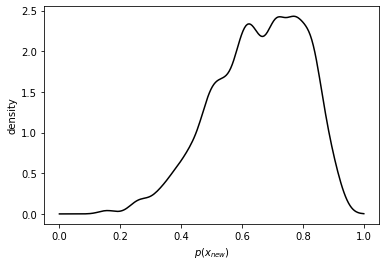

In [48]:
yspace = np.linspace(0, 1, mplot)
plt.plot(yspace, density(yspace), color='black')
plt.xlabel(r'$p(x_{new})$')
plt.ylabel('density')
plt.show()

Assumptions: The model may be extrapolated to dosages for which we have no data.

#### (e)

In [49]:
predictive = np.zeros(m + 1)

for k in range(m + 1):
    predictive[k] = math.comb(m, k) * np.mean(pxnew_sample**k * (1 - pxnew_sample)**(m - k))

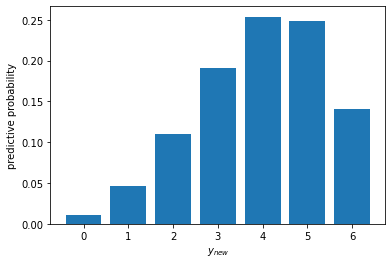

In [50]:
plt.bar(np.arange(m + 1), predictive)
plt.xlabel(r'$y_{new}$')
plt.ylabel('predictive probability')
plt.show()

#### (f)

In [51]:
sim = 100_000
sample = np.zeros((sim, 2))

for s in range(sim - 1):
    if s == 0:
        sample[s] = 16 * np.random.random(2) - 8
    else:
        current = sample[s]
        proposal = sample[s] + (2 * np.random.random(2) - 1)
        if np.max(proposal) > 8 or proposal[0] < -8 or proposal[1] < 0:
            sample[s + 1] = current
        else:
            log_acceptance_prob = ell(proposal[0], proposal[1], x, y) - ell(current[0], current[1], x, y)
            U = np.random.random()
            if np.log(U) < log_acceptance_prob:
                sample[s + 1] = proposal
            else:
                sample[s + 1] = current
                
### burn-in
sample = sample[int(.05 * sim):]

In [52]:
ess1 = az.ess(sample[:, 0])
ess2 = az.ess(sample[:, 1])

print(f'ESS for a: {np.round(ess1, 2)}')
print(f'ESS for b: {np.round(ess2, 2)}')

ESS for a: 5015.97
ESS for b: 5536.45


#### LD50

In [53]:
LD50_sample = -sample[:, 0] / sample[:, 1]
print(f'Posterior 0.05 quantile of LD50: {np.round(np.quantile(LD50_sample, .05), 4)}')
print(f'Posterior 0.50 quantile of LD50: {np.round(np.quantile(LD50_sample, .50), 4)}')
print(f'Posterior 0.95 quantile of LD50: {np.round(np.quantile(LD50_sample, .95), 4)}')

Posterior 0.05 quantile of LD50: 0.9895
Posterior 0.50 quantile of LD50: 1.5448
Posterior 0.95 quantile of LD50: 3.6891
